In [24]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
# model selection and optimization
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
# feature selection
from sklearn.feature_selection import SelectFromModel
# model evaluation
from sklearn.metrics import *
# data split train-test
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sb

from os import path

import time
import warnings

warnings.filterwarnings(action='ignore')
orig_data_df = pd.read_csv('./dataset/creditcard.csv')

# First glance on data

In [2]:
print("Dataset dimension: ", orig_data_df.shape)
print("Attributes: ", orig_data_df.columns)
print("\nShow first 5 rows:\n", orig_data_df[['Time', 'Amount', 'Class']].head(5))
print("\nDescribe dataset:\n", orig_data_df[['Time', 'Amount', 'Class']].describe())
print("\nClass distribution:\n", orig_data_df.groupby('Class')['Class'].value_counts())

Dataset dimension:  (284807, 31)
Attributes:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Show first 5 rows:
    Time  Amount  Class
0   0.0  149.62      0
1   0.0    2.69      0
2   1.0  378.66      0
3   1.0  123.50      0
4   2.0   69.99      0

Describe dataset:
                 Time         Amount          Class
count  284807.000000  284807.000000  284807.000000
mean    94813.859575      88.349619       0.001727
std     47488.145955     250.120109       0.041527
min         0.000000       0.000000       0.000000
25%     54201.500000       5.600000       0.000000
50%     84692.000000      22.000000       0.000000
75%    139320.500000      77.165000       0.000000
max    172792.000000   25691.160000       1.000000

Class distribution:
 Class  Class
0      0        

# Divide dataset into train and test samples
## Train: 80% Test: 20%

In [3]:
## Divide dataset into train and test samples
### Train: 80% Test: 20%
train_dataset_df, test_dataset_df = train_test_split(orig_data_df, test_size=.2, shuffle=True, stratify=orig_data_df[['Class']])

# We expect the following distribution: Train: 227845 {394 istances of class 1, 227452 istances of class 0}
print("\nSize training instances: {}\nSize test instances: {}".format(train_dataset_df.shape, test_dataset_df.shape))
print("\nGroupby 'class' training dataset:\n\n ", train_dataset_df.groupby('Class')['Class'].count())
print("\nGroupby 'class' test dataset:\n\n ", test_dataset_df.groupby('Class')['Class'].count())


Size training instances: (227845, 31)
Size test instances: (56962, 31)

Groupby 'class' training dataset:

  Class
0    227451
1       394
Name: Class, dtype: int64

Groupby 'class' test dataset:

  Class
0    56864
1       98
Name: Class, dtype: int64


# Save datasets.
### ATTENTION: It is allowed to use fraud_testing.csv only once when the model is ready for final tests!!!!

In [4]:
# Save datasets.
# ATTENTION: It is allowed to use fraud_testing.csv only once when the model is ready for final tests!!!!
print('ATTENTION: It is allowed to use fraud_testing.csv only once when the model is ready for final tests!!!!')
if path.exists('./dataset/fraud_testing.csv') != True:
    train_dataset_df.to_csv('./dataset/fraud_training.csv')
    test_dataset_df.loc[test_idx].to_csv('./dataset/fraud_testing.csv')
    print(pd.read_csv('./dataset/fraud_testing.csv').groupby('Class')['Class'].count())

ATTENTION: It is allowed to use fraud_testing.csv only once when the model is ready for final tests!!!!


# Building a baseline model

## Load previously saved training dataset and split it into test and training samples

In [13]:
# Load previously saved training dataset and split it into test and training samples
training_data_df = pd.read_csv('./dataset/fraud_training.csv', index_col=0)
df_train_train, df_test_train = train_test_split(training_data_df, test_size=.2, shuffle=True, stratify=training_data_df[['Class']], random_state=np.random.RandomState())

print("\n Show dimensions: \n\n")
print("Training baseline dataset:")
print(df_train_train.shape)
print("\nTesting baseline dataset:")
print(df_test_train.shape)

print("\n Show distributions of 'Class': \n\n")
print("Training baseline dataset\n")
print(df_train_train.groupby('Class')['Class'].count())
print("\nTesting baseline dataset\n")
print(df_test_train.groupby('Class')['Class'].count())


 Show dimensions: 


Training baseline dataset:
(182276, 31)

Testing baseline dataset:
(45569, 31)

 Show distributions of 'Class': 


Training baseline dataset

Class
0    181961
1       315
Name: Class, dtype: int64

Testing baseline dataset

Class
0    45490
1       79
Name: Class, dtype: int64


## Pickup the best baseline model and show its stats

In [33]:
# Pickup the best baseline model and show its stats

import time

set_classifiers = {
    'DummyClassifier': {
        'model': DummyClassifier()
    },
    'LogisticRegression': {
        'model': LogisticRegression()
    },
    'DecisionTrees': {
        'model': DecisionTreeClassifier()
    },
    'RandomForest': {
        'model': RandomForestClassifier()
    },
    'SVM': {
        'model': LinearSVC()
    },
    'MLPClassifier': {
        'model': MLPClassifier()
    }
}

X_train_baseline = df_train_train.iloc[:, :-1]
y_train_baseline = df_train_train[['Class']].to_numpy().flatten()

X_test_baseline = df_test_train.iloc[:, :-1]
y_test_baseline = df_test_train[['Class']].to_numpy().flatten()

for model_name, model_info in set_classifiers.items():
    print('*'*80)
    model_name = model_name + '_default'
    print(f'Training model {str(model_name)}\n')

    clf = model_info['model']
    start = time.time()
    clf.fit(X_train_baseline, y_train_baseline)
    y_pred_baseline = clf.predict(X_test_baseline)
    end = time.time()
    print("\n{}".format(classification_report(y_test_baseline, y_pred_baseline)))
    print('roc_auc_score_weighted: ', roc_auc_score(y_test_baseline, y_pred_baseline, average='weighted'))
    print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_test_baseline, y_pred_baseline)))
    print("\nTraining time: ", end-start)

********************************************************************************
Training model DummyClassifier_default


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.00      0.00      0.00        79

    accuracy                           1.00     45569
   macro avg       0.50      0.50      0.50     45569
weighted avg       1.00      1.00      1.00     45569

roc_auc_score_weighted:  0.4992635744119587

Confusion matrix:
[[45423    67]
 [   79     0]]


Training time:  0.012042045593261719
********************************************************************************
Training model LogisticRegression_default


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.65      0.61      0.63        79

    accuracy                           1.00     45569
   macro avg       0.82      0.80      0.81     45569
weighted avg       1.

## Data exploration

### We consider only Amount and Time variables while the others V1, ..., V31, are left from the analysis because they are derived from PCA

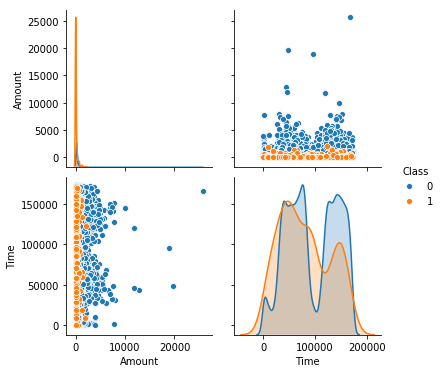

In [7]:
sb.pairplot(training_data_df.loc[:, ['Amount', 'Time', 'Class']], hue="Class")

### Drill down on 'Amount' variable

          count        mean         std  min   25%    50%      75%       95%  \
Class                                                                          
0      227451.0   88.102649  250.200573  0.0  5.54  21.99   76.800  364.4400   
1         394.0  123.406980  264.490897  0.0  1.00   9.17  103.375  654.8425   

             99%       max  
Class                       
0      1020.0000  25691.16  
1      1356.7217   2125.87  


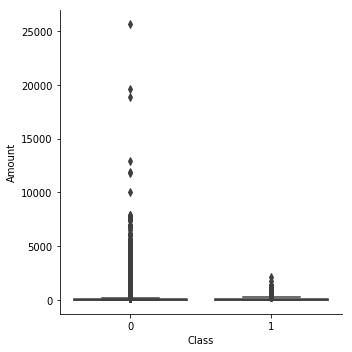

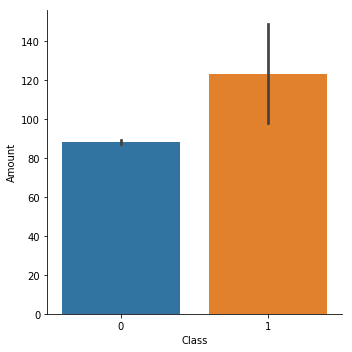

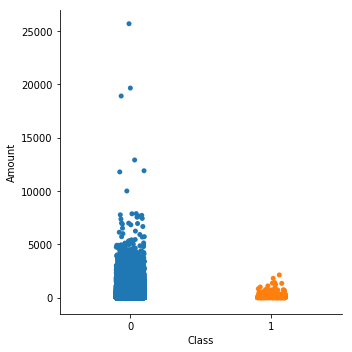

In [5]:
data_training_amount = training_data_df.loc[:, ['Amount', 'Class']]
print(data_training_amount.groupby("Class")["Amount"].describe(percentiles=[.25, .5, .75, .95, .99]))
sb.catplot(x="Class", y="Amount", kind="box", data=data_training_amount)
sb.catplot(x="Class", y="Amount", kind="bar", data=data_training_amount)
sb.catplot(x="Class", y="Amount", data=data_training_amount)


### Drill down on 'Time' variable

          count          mean           std    min       25%      50%  \
Class                                                                   
0      227451.0  94751.122976  47498.595588    0.0  54177.00  84606.0   
1         394.0  80365.677665  47517.511566  406.0  41309.25  73783.5   

            75%       95%        99%       max  
Class                                           
0      139241.5  164129.0  170578.50  172792.0  
1      125509.0  156217.0  169156.35  170348.0  


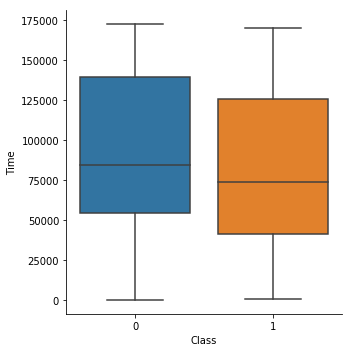

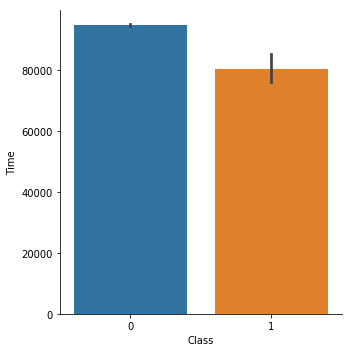

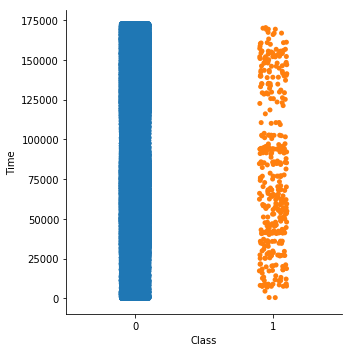

In [8]:
data_training_time = training_data_df.loc[:, ['Time', 'Class']]
print(data_training_time.groupby("Class")["Time"].describe(percentiles=[.25, .5, .75, .95, .99]))
sb.catplot(x="Class", y="Time", kind="box", data=data_training_time)
sb.catplot(x="Class", y="Time", kind="bar", data=data_training_time)
sb.catplot(x="Class", y="Time", data=data_training_time)

### Transform 'Time' into 24 hours interval

          count       mean       std  min   25%   50%   75%   95%   99%   max
Class                                                                        
0      227451.0  14.050503  5.833410  0.0  10.0  15.0  19.0  22.0  23.0  23.0
1         394.0  11.657360  6.681169  0.0   5.0  12.0  17.0  22.0  23.0  23.0


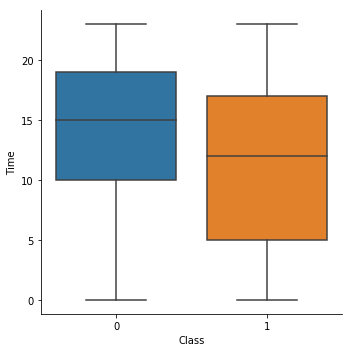

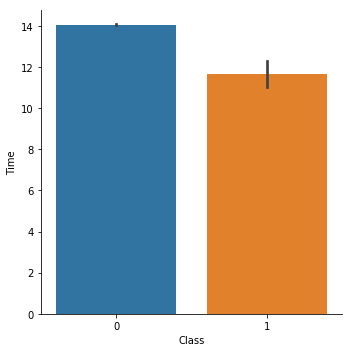

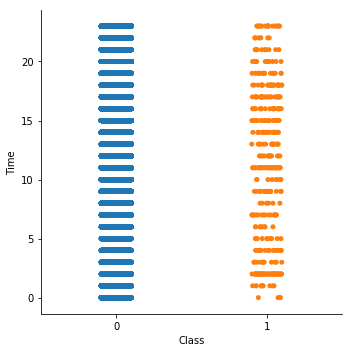

In [9]:
# transform into 24 hours
data_training_time.loc[:, 'Time'] = data_training_time.loc[:, 'Time'].apply(lambda x: int(x / 3600 % 24))
print(data_training_time.groupby("Class")["Time"].describe(percentiles=[.25, .5, .75, .95, .99]))
sb.catplot(x="Class", y="Time", kind="box", data=data_training_time)
sb.catplot(x="Class", y="Time", kind="bar", data=data_training_time)
sb.catplot(x="Class", y="Time", data=data_training_time)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f422545e450>,
      dtype=object)

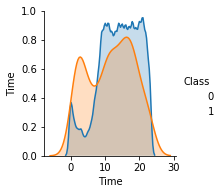

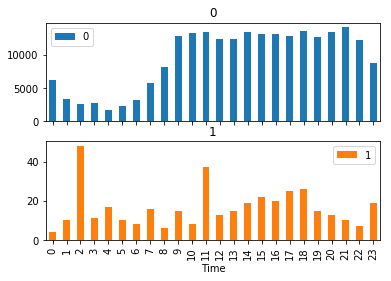

In [10]:
sb.pairplot(data_training_time, kind='hist', x_vars='Time', y_vars='Time', hue="Class")

time_grp = data_training_time.groupby(["Time", "Class"])['Class']
time=time_grp.size().unstack(level=1)
class1 = time.iloc[:, 1]
time.plot(kind='bar', subplots=True)

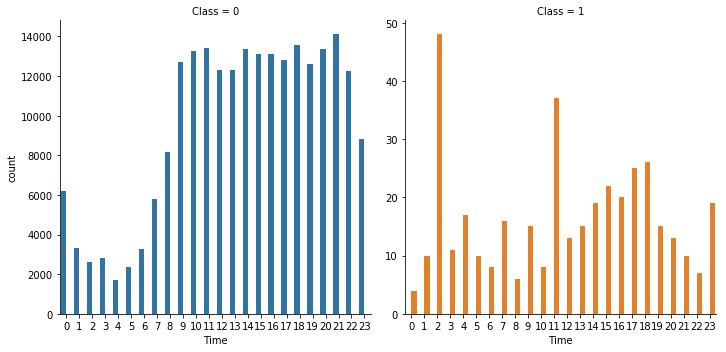

In [11]:
sb.catplot(x="Time", col="Class", col_wrap=2,
                data=data_training_time, dodge=True,
                kind="count", sharey=False, hue="Class")

### Test 'Time' transformation into 24 hours interval

In [22]:
X_trans_train = df_train_train.iloc[:, :-1]
X_trans_test = df_test_train.iloc[:, :-1]
y_trans_train = df_train_train[['Class']].to_numpy().flatten()
y_trans_test = df_test_train[['Class']].to_numpy().flatten()

X_trans_train.loc[:, 'Time'] = X_trans_train.loc[:, 'Time'].apply(lambda x: int(x / 3600 % 24))
X_trans_test.loc[:, 'Time'] = X_trans_test.loc[:, 'Time'].apply(lambda x: int(x / 3600 % 24))

In [27]:
for clf in [DecisionTreeClassifier(),RandomForestClassifier()]:
    print("*"*80)
    print(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_trans_train, y_trans_train)
    y_trans_pred = clf.predict(X_trans_test)
    end = time.time()
    print("\n{}".format(classification_report(y_trans_test, y_trans_pred)))
    print('roc_auc_score_weighted: ', roc_auc_score(y_trans_test, y_trans_pred, average='weighted'))
    print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_trans_test, y_trans_pred)))
    print("\nTraining time: ", end-start)

********************************************************************************
DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.81      0.73      0.77        79

    accuracy                           1.00     45569
   macro avg       0.90      0.87      0.88     45569
weighted avg       1.00      1.00      1.00     45569

roc_auc_score_weighted:  0.8669347276213161

Confusion matrix:
[[45476    14]
 [   21    58]]


Training time:  27.162827491760254
********************************************************************************
RandomForestClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.92      0.70      0.79        79

    accuracy                           1.00     45569
   macro avg       0.96      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569

roc_a

## Feature selections

In [31]:
#sel = SelectFromModel(RandomForestClassifier())
print(X_trans_train.shape)
print(y_trans_train.shape)
#sel.fit(X_trans_train, y_trans_train)
print("Important features: \n")
best_features = X_trans_train.columns[(sel.get_support())]
print(best_features)

(182276, 30)
(182276,)
Important features: 

Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17'], dtype='object')


In [33]:
X_train_sel = df_train_train.loc[:, best_features]
X_test_sel = df_test_train.loc[:, best_features]

y_train_sel = df_train_train[['Class']].to_numpy().flatten()
y_test_sel = df_test_train[['Class']].to_numpy().flatten()

In [34]:
clf = RandomForestClassifier()
clf.fit(X_train_sel, y_train_sel)
y_pred_sel = clf.predict(X_test_sel)
print("\n{}".format(classification_report(y_test_sel, y_pred_sel)))
print('roc_auc_score_weighted: ', roc_auc_score(y_test_sel, y_pred_sel, average='weighted'))
print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_test_sel, y_pred_sel)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.88      0.72      0.79        79

    accuracy                           1.00     45569
   macro avg       0.94      0.86      0.90     45569
weighted avg       1.00      1.00      1.00     45569

roc_auc_score_weighted:  0.8606715622573885

Confusion matrix:
[[45482     8]
 [   22    57]]



In [44]:
for clf in [DecisionTreeClassifier(), RandomForestClassifier()]:
    print("*"*80)
    print(clf.__class__.__name__)
    
    sel = SelectFromModel(clf)
    sel.fit(X_trans_train, y_trans_train)
    print("Important features: \n")
    best_features = X_train_baseline.columns[(sel.get_support())]
    print(best_features)

    X_train_sel = X_trans_train.loc[:, best_features]
    X_test_sel = X_trans_test.loc[:, best_features]
    y_train_sel = y_train_baseline
    y_test_sel = y_test_baseline

    start = time.time()
    clf.fit(X_train_sel, y_train_sel)
    y_pred_sel = clf.predict(X_test_sel)
    end = time.time()
    
    print("\n{}".format(classification_report(y_test_sel, y_pred_sel)))
    print('roc_auc_score_weighted: ', roc_auc_score(y_test_sel, y_pred_sel, average='weighted'))
    print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_test_sel, y_pred_sel)))
    print("\nTraining time: ", end-start)

********************************************************************************
DecisionTreeClassifier
Important features: 

Index(['V10', 'V12', 'V14', 'V17'], dtype='object')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.73      0.67      0.70        79

    accuracy                           1.00     45569
   macro avg       0.86      0.84      0.85     45569
weighted avg       1.00      1.00      1.00     45569

roc_auc_score_weighted:  0.8352232094409398

Confusion matrix:
[[45470    20]
 [   26    53]]


Training time:  2.796205759048462
********************************************************************************
RandomForestClassifier
Important features: 

Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.97      0.72      0.83        79




## Model optimization

In [51]:
best_features = ['V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
X_opt = train_dataset_df.loc[:, best_features]
y_opt = train_dataset_df[['Class']].to_numpy().flatten()

print(X_opt.columns, X_opt.shape)
print(y_opt.shape)

forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_opt.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [None]
}

set_classifiers = {
    'DecisionTrees': {
        'model': DecisionTreeClassifier(),
        'params': tree_param_grid
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': forest_param_grid
    }
}

sss = StratifiedShuffleSplit(n_splits=3, test_size=.2, random_state=None)
classifiers_info = dict()
start_global = time.time()

for model_name, model_info in set_classifiers.items():
    print("*"*80)
    clf_key = model_name
    print(f'Training model {clf_key}\n')
    classifiers_info[clf_key] = {}
    rnd_search = RandomizedSearchCV(model_info['model'],
                                    model_info['params'],
                                    scoring='f1_weighted', # READ THE NOTE BELOW
                                    cv=sss,
                                    verbose=3,
                                    n_jobs=-1)
    start = time.time()
    rnd_search.fit(X_opt, y_opt)
    end = time.time() 
    classifiers_info[clf_key]['estimator'] = rnd_search
    print("\nTraining time: ", end - start)

end_global = time.time()
print("\nGridSearch time: ", end_global - start_global)

"""
NOTE:

'f1_weighted':
Calculate metrics for each label, and find their average weighted by support 
(the number of true instances for each label). This alters ‘macro’ to account 
for label imbalance; it can result in an F-score that is not between precision and recall.
"""

Index(['V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object') (227845, 7)
(227845,)
********************************************************************************
Training model DecisionTrees{'criterion': ['entropy', 'gini'], 'max_depth': [3, 5, 10, 20], 'max_features': array([1, 2, 3, 4, 5, 6]), 'class_weight': ['balanced', None], 'random_state': [42]}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.9s finished



Training time:  46.6260027885437
********************************************************************************
Training model RandomForest{'bootstrap': [True, False], 'max_depth': [3, 5, 10, 20, 50], 'n_estimators': [50, 100, 200, 500], 'max_features': ['auto', 'sqrt'], 'class_weight': ['balanced', None]}

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 43.2min finished



Training time:  2694.097030878067

GridSearch time:  2740.72700047493


"\nNOTE:\n\n'f1_weighted':\nCalculate metrics for each label, and find their average weighted by support \n(the number of true instances for each label). This alters ‘macro’ to account \nfor label imbalance; it can result in an F-score that is not between precision and recall.\n"

In [65]:
rf_clf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Best estimators


dict_values([{'estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')}, {'estimator': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_sta

## Model evaluation

In [16]:
best_features = ['V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']
df_train, df_test = train_test_split(training_data_df.loc[:, best_features+['Class']], 
                                                 test_size=.2, shuffle=True, 
                                                 stratify=training_data_df[['Class']], 
                                                 random_state=np.random.RandomState())
X_train = df_train.iloc[:, :-1]
y_train = df_train[['Class']].to_numpy().flatten()
X_test = df_test.iloc[:, :-1]
y_test = df_test[['Class']].to_numpy().flatten()

In [18]:
rf_clf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

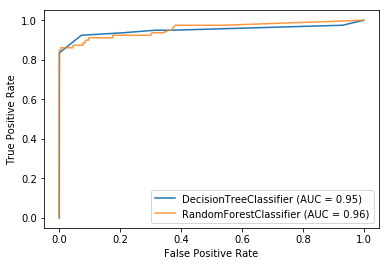

In [20]:
import matplotlib.pyplot as plt

dt_disp = plot_roc_curve(dt_clf, X_test, y_test)
ax = plt.gca()
rf_disp = plot_roc_curve(rf_clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

This difference exists because, in this dataset, the number of non-fraud cases greatly exceeds the number of fraud cases. Consequently, a large change in the number of false positives can lead to a small change in the false positive rate used in ROC analysis.

Precision, on the other hand, by comparing false positives to true positives rather than true negatives, captures the effect of the large number of negative examples on the algorithm’s performance”

Precision accounts for this imbalance, as it’s just looking at how accurate our positive predictions are. For these reasons, we have chosen precision-recall curves for hyperparameter tuning and model selection (algorithms optimizing for the area under the ROC curve are not guaranteed to optimize for the area under the PR curve).


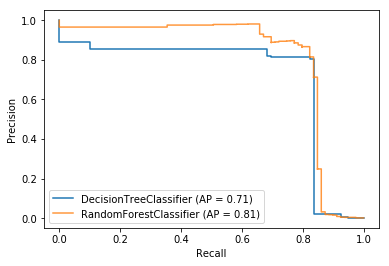

In [33]:
dt_disp = plot_precision_recall_curve(dt_clf, X_test, y_test)
ax = plt.gca()
rf_disp = plot_precision_recall_curve(rf_clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [35]:
for clf in [dt_clf, rf_clf]:
    print("*"*80)
    print(clf.__class__.__name__)
    y_pred = clf.predict(X_test)
    print("\n{}".format(classification_report(y_test, y_pred)))
    print('roc_auc_score_weighted: ', roc_auc_score(y_test, y_pred, average='weighted'))
    print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_test, y_pred)))
    print("Average precision score: ", average_precision_score(y_test, y_pred))
    print("Balanced: accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, y_pred))
    print("Jaccard score: ", jaccard_score(y_test, y_pred))
    

********************************************************************************
DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.80      0.84      0.82        79

    accuracy                           1.00     45569
   macro avg       0.90      0.92      0.91     45569
weighted avg       1.00      1.00      1.00     45569

roc_auc_score_weighted:  0.9175456561603468

Confusion matrix:
[[45474    16]
 [   13    66]]

Average precision score:  0.6727150439330845
Balanced: accuracy:  0.9175456561603468
Matthews correlation coefficient:  0.8196999452886456
Jaccard score:  0.6947368421052632
********************************************************************************
RandomForestClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45490
           1       0.88      0.77      0.82        79

    accuracy                  

False Positive (FP) - predicting fraud when the transaction was not fraud

Consequences: Card is locked, card owner calls & explains the mistake, short investigation (security questions etc.), card is unlocked
Estimated business cost: Low
False Negative (FN) - predicting not fraud when the transaction was fraud

Consequences: Fraud is reported, card is locked, larger investigation takes place, card company liable for refunding
Estimated business cost: High
It would therefore seem that our goals should really be to minimize false negatives as much as possible, but not to the point of diminishing returns where a ridiculous number of transactions are being blocked. I’ll have to make some fairly broad assumptions (limited information), but business knowledge would help here in industry.

Assumptions:

cost(FN) = cost of fraud refund + 3hrs investigation
cost(FP) = 20min investigation
The cost of a fraud refund is the dataset average fraud value: 122.21
The cost of 1hr investigation time is the average call-centre hourly pay: £7.80
I therefore end up at the costs seen below:

cost(FN) = 145.6113211
cost(FP) = 2.6

# Model testing

In [35]:
test_data_df = pd.read_csv('./dataset/fraud_testing.csv', index_col=0)

best_features = ['V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

X_test = test_data_df.loc[:, best_features]
y_test = test_data_df[['Class']].to_numpy().flatten()

X_train = training_data_df.loc[:, best_features]
y_train = training_data_df[['Class']].to_numpy().flatten()

In [36]:
dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

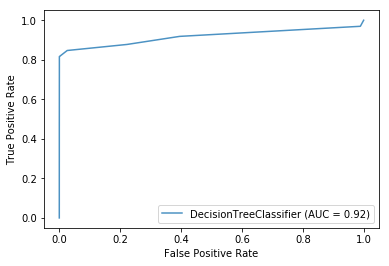

In [39]:
plot_roc_curve(dt_clf, X_test, y_test, alpha=0.8)

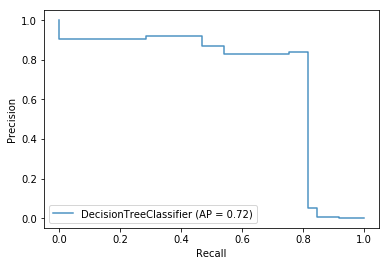

In [41]:
plot_precision_recall_curve(dt_clf, X_test, y_test, alpha=0.8)


In [44]:
for clf in [dt_clf]:
    print("*"*80)
    print(clf.__class__.__name__)
    y_pred = clf.predict(X_test)
    print("\n{}".format(classification_report(y_test, y_pred)))
    print('roc_auc_score_weighted: ', roc_auc_score(y_test, y_pred, average='weighted'))
    print("\nConfusion matrix:\n{}\n".format(confusion_matrix(y_test, y_pred)))
    print("Average precision score: ", average_precision_score(y_test, y_pred))
    print("Balanced: accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("Matthews correlation coefficient: ", matthews_corrcoef(y_test, y_pred))
    print("Jaccard score: ", jaccard_score(y_test, y_pred))

********************************************************************************
DecisionTreeClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

roc_auc_score_weighted:  0.9080313716651546

Confusion matrix:
[[56849    15]
 [   18    80]]

Average precision score:  0.6877488680244402
Balanced: accuracy:  0.9080313716651545
Matthews correlation coefficient:  0.8288259313544596
Jaccard score:  0.7079646017699115


# Conclusion

## Business impact

The total dataset is data taken over a 2-day period, and test data is 20% of this.

- 246 frauds per day
- If we fail to predict any of these (i.e. with NO fraud detection system), they will all take the ‘false negative’ cost: 145.61
    - Annual business cost = __(€ 145.61)(246)(365) = € 13,074,440.52__

With our final model, we achieved errors of 18 FN’s and 15 FP’s, with a __€ 2649__

__New annual business cost__ = (€ 2649)(2)(365) = __€ 1,933,770__

Therefore, an upper bound estimate for __annual cost-savings__ is: € 13.074.440 - € 1.933.770 =~ __€ 11.14M__

This is a __reduction in fraud-handling costs of ~85%__!

# References
https://www.kaggle.com/mlg-ulb/creditcardfraud/notebooks?sortBy=voteCount&group=everyone&pageSize=20&datasetId=310

## Winners
https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets#Test-Data-with-Logistic-Regression:

## Good explanantion
https://www.kaggle.com/lmorgan95/fraud-detection-smote-xgboost-business-impact#cut-off-experimentation
https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis
https://www.kaggle.com/dstuerzer/optimized-logistic-regression#Validation-of-the-final-model

## Ideas to get from
https://www.kaggle.com/lmorgan95/fraud-detection-smote-xgboost-business-impact#cut-off-experimentation
https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights
https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis
https://www.kaggle.com/dstuerzer/optimized-logistic-regression#Validation-of-the-final-model
https://www.kaggle.com/nareshbhat/fraud-detection-feature-selection-over-sampling

## Data exploration
https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models#Load-packages

## Imbalanced dataset
https://www.kaggle.com/gargmanish/how-to-handle-imbalance-data-study-in-detail
https://www.kaggle.com/qianchao/smote-with-imbalance-data
https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data
https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
https://www.kaggle.com/parvezahmedshaikh/smote-and-undersampling-credit-card-fraud-dataset

## No ROC
https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve#Conclusion

## Precision vs Recall and F1
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights

## Hyperparameters tuning
https://www.kaggle.com/pavansanagapati/automated-hyperparameter-tuning
https://www.kaggle.com/thiagopanini/credit-fraud-how-to-choose-the-best-classifier

## Blogs
https://medium.com/@vitorgabo/credit-card-fraud-detection-34935dda1a4d
https://medium.com/@Nethone_/a-beginners-guide-to-machine-learning-in-payment-fraud-detection-prevention-360c95a9ca54